<a href="https://colab.research.google.com/github/thebrownkid/3dprinted-face-shield/blob/master/Dataset2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Muhammad Rakibul Islam

**Language: Python**

**ML Library: scikit-learn**

**Original Dataset Source**: [The ISOT Fake News Dataset](https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/) (University of Victoria); Downloaded from [Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?resource=download&select=True.csv).

**Dataset Acknowledgements (acquired from source)**:

1.   Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018.
2.   Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

**Notebook Inspiration Acknowledgement**:

This notebook has been adapted from a class notebook by [Professor Lisa Rhody](https://www.gc.cuny.edu/people/lisa-rhody) for the course "Methods of Text Analysis" taught at the CUNY Graduate Center.

**Notebook Acknowledgement**:

This notebook draws heavily from Chapter 6 of [**Blueprints for Text Analysis Using Python**](https://github.com/blueprints-for-text-analytics-python/blueprints-text)  
Jens Albrecht, Sidharth Ramachandran, Christian Winkler.

#Dataset Pre-processing

Notes to be Added Here

To be added

In [ ]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch06/setup.py')

%run -i setup.py

You are working on Google Colab.
Files will be downloaded to "/content".
!wget -P /content https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/settings.py
!wget -P /content/data/jdt-bugs-dataset https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/jdt-bugs-dataset/eclipse_jdt.csv.gz
!wget -P /content/packages/blueprints https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/packages/blueprints/preparation.py
!wget -P /content/ch06 https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/ch06/requirements.txt

Additional setup ...
!pip install -r ch06/requirements.txt


## Load Python Settings<div class="tocSkip"/>

In [ ]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# path to import blueprints packages
sys.path.append(BASE_DIR + '/packages')

In [ ]:
import matplotlib.pyplot as plt
import html
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from blueprints.preparation import clean

##Mounting Google Drive

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the CSV file on Google Drive
file_path = '/content/drive/MyDrive/Data71200/CapstoneDatasets/Dataset2.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Print column names
print(df.columns)

# Select specific columns from the DataFrame
selected_columns = ['text', 'category']
selected_data = df[selected_columns].sample(2, random_state=42)

# Print the selected data
print(selected_data)

Index(['text', 'category', 'news_source'], dtype='object')
                                                                                                                                                                                                          text  \
11941  The election is Tuesday. So it s time to make my final case for Donald J. Trump. My case is pretty simple   it s Trump or it s the end of America.I was raised as a middle-class kid in the greatest...   
30652  Updated at 1 p. m. ET, North Korea has released American college student Otto Warmbier, who is on his way back to the U. S. and won‚Äôt be forced to serve a   prison term, according to Secretary o...   

      category  
11941     fake  
30652     TRUE  


In [ ]:
# Remove duplicates from "title" column
#df = df.drop_duplicates(subset=['title'])

# Remove duplicates from "text" column
df = df.drop_duplicates(subset=['text'])

# Verify the resulting DataFrame
print(df.head())

                                                                                                                                                                                                      text  \
0      (Welcome) to America We hope you enjoy our benefits. Please feel free to NOT assimilate  Coming soon: Press 1 for English, 2 for Spanish and 3 for Arabic The Obama Administration is on pace to...   
1     Delta Air Lines and Bank of America became the first companies to announce they are pulling their sponsorships of a Manhattan-based theater company s portrayal of Julius Caesar as a Donald Trum...   
2     #PresidentElectTrumpABSOLUTELY MUST WATCHToday there is hope for the American people.We will #MakeAmericaGreatAgainPlease RT pic.twitter.com/WSbpcKr8np  Brian Fraser (@bfraser747) November 9, 2016   
3    Episode #174 of SUNDAY WIRE SHOW resumes this February 19, 2017 as host Hesher brings you this week s special LIVE broadcast on the Alternate Current Radio Network LISTEN 

In [ ]:
# Check the number of rows remaining
num_rows = df.shape[0]
print("Number of rows remaining:", num_rows)

Number of rows remaining: 32286


fake    16252
TRUE    16033
Name: category, dtype: int64

<Axes: >

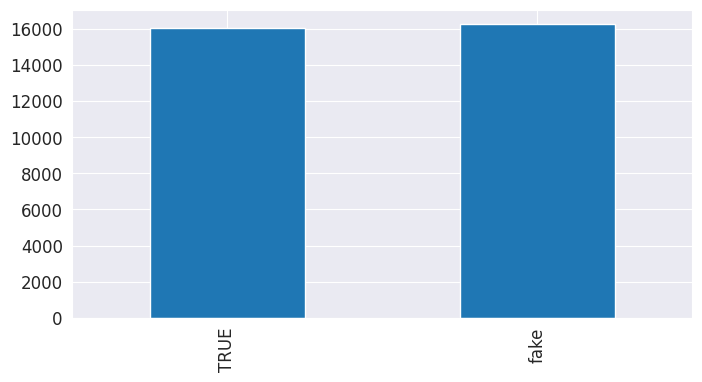

In [ ]:
# let's see the breakdown of the "category" column and draw a bar chart to see
df['category'].value_counts()
df['category'].value_counts().sort_index().plot(kind='bar')

## For our ease, we will combine the title and text columns into a new combined column

In [ ]:
#df = df[['title','text','category']]
#df = df.dropna()
#df['combined_text'] = df['title'] + ' ' + df['text']
#df = df.drop(columns=['title','text'])
#df.columns

In [ ]:
from blueprints.preparation import clean
df = df.dropna(subset=['text'])
df = df[df['text'].apply(lambda x: isinstance(x, str))]
df['text'] = df['text'].apply(clean)
df.sample(2, random_state=0)

,text,category,news_source
23803,"WASHINGTON ‚Äî Picking themselves up after the bruising collapse of their health care plan, President Trump and Republicans in Congress will start this week on a legislative obstacle course that w...",TRUE,New York Times
22727,"Damien Chazelle, the writer and director of the musical ‚ÄúLa La Land,‚Äù never had any doubts about Los Angeles as an artistic canvas. From the film‚Äôs opening, with commuters dancing and singin...",TRUE,New York Times


In [ ]:
# Extract the name column
name_column = df.iloc[0]

# Randomize the rows while excluding the name column
randomized_df = df.iloc[1:].sample(frac=1, random_state=42).reset_index(drop=True)

# Concatenate the name column back to the randomized DataFrame
randomized_df = pd.concat([name_column.to_frame().T, randomized_df])

# Print the randomized DataFrame
print(randomized_df)

                                                                                                                                                                                                          text  \
0      (Welcome) to America We hope you enjoy our benefits. Please feel free to NOT assimilate Coming soon: Press 1 for English, 2 for Spanish and 3 for Arabic The Obama Administration is on pace to issu...   
0      WASHINGTON (Reuters) U.S. Senator Bob Corker, the influential Republican chairman of the Senate Foreign Relations Committee, said on Tuesday he will not run for re-election, a blow to a party alre...   
1      White House officials are now saying Trump won t make a trip to England this summer after a hurried, secret plan to sneak the president into the country was leaked to the English press causing wid...   
2      BEIRUT (Reuters) An air strike carried out by an unidentified warplane killed seven Hezbollah fighters in eastern Syria, three sources familiar with the 

##Splitting dataset into train & test sets (80-20 split)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['category'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['category'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  25828
Size of Test Data  6457


##Text vectorization

We are vectorizing the text using the tf-idf vectorizer (which means that we want to make sure that words that appear very frequently and not frequently at all do not skew the model)

In [ ]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

Then we're going to use "support vectors" to train a model. Linear SVM is a very popular text classification algorithm. In this model, the computers uses the relationships between vectors to create a line where there is the greatest separation between two classes. There may be more than one possible line. The algorithm chooses the line that provides the maximum separation between the closest points in two classes. Because the computer needs to know where to start its random process of evaluating vectors, we have to set a `random_state`. The tolerance level is how much room for error we are willing to live with. In this case, it is input in scientific notation, and a much simpler way of indicating 0.00001.

In [ ]:
# The output of the LinearSVC (Lindear Support Vector Classification) is a
# model file, which is an object with multiple components. The model itself
# isn't instructive or useful until we evaluate it and apply it to tasks.
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

##Model Evaluation

In [ ]:
# Now we want to take the test dataset and we're going to use it
# to evaluate how accurately the model can predict whether text is
# associated with a true or fake label or not. Notice we are skipping the fit
# step and going straight to vectorizing. In other words, we are not
# asking the model to learn new vocabulary.
X_test_tf = tfidf.transform(X_test)

In [ ]:
# We evaluate how well the model did by running the predict method on the X test
# sample of data and then compare the predicted values to the actual labels.
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.9964379742914666


### Results
The accuracy score is a proportion and can be interpreted as a percentage. In other words, there's an X% likelihood that the model will be abe to predict whether or not the text is associated with a certain label. It's a good idea to consider whether or not the accuracy is more or less likely than other methods of estimating. For example, is it better than the odds of tossing a coin and getting it right? Or, could you roll a dice and get a better likelihood of the right answer?

So, one way to do this is to compare the result to something more naive like the DummyClassifier, where the baseline model always predicts the class with the highest frequency or that is "stratified" which is to say it makes predictions based on the proportion of labels in the training dataset.

In [ ]:
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=42, strategy='most_frequent')

Accuracy Score -  0.5033297196840638


The DummyClassifier provides an accuracy score of about 55% while our more complex trained model is 99% accurate. That is a significant different and does show that our model is in fact learning well from the dataset and not giving out simplified or at random predictions.

However, to test things even further, we can build something called a *confusion matrix*. In a [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62), we compare the actual values with the predicted values.

### Precision and Recall
What makes a confusion matrix useful is that we can use this matrix of numbers to measure the proportion of predicted positives that were actually positive, which is another measure of how accurate the predictions are.

Precision is the number of times the model correctly predicts a variable to be in a category, divided by the total number of accurate predictions.

Recall is the number of times that the model makes the right class assignment (true positive) divided by the number of times it is completely correct and completely incorrect (True positive + false negative).

In [ ]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[3191,   16],
       [   7, 3243]])

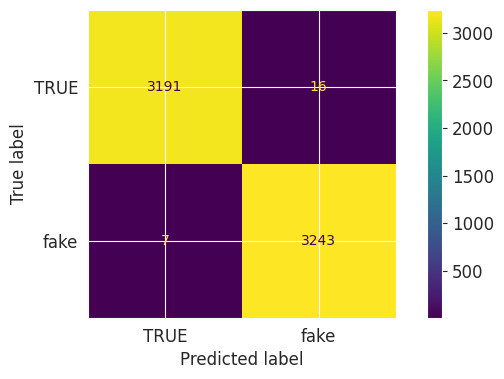

In [ ]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

In [ ]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

        TRUE       1.00      1.00      1.00      3207
        fake       1.00      1.00      1.00      3250

    accuracy                           1.00      6457
   macro avg       1.00      1.00      1.00      6457
weighted avg       1.00      1.00      1.00      6457



# Cross-Validation (wasn’t able to carry out because of computational power needed)

One way to test whether or not the results are an artifact of the random selection of data and the shuffling of data order could be to set a new `random_state` which would shuffle the data and could result in a different accuracy outcome. We won't know until we try.

Cross-validation is when we train a model on different splits of the data and validate on different splits of data so that the model achieves a balance between *underfitting* and *overfitting*. Underfitting happens when the  model is complex and has fit the underlying pattern well during training but produces significant deviations during the testing phase. In this case, the model has been trained too narrowly on the data and doesn't do a good job of generalizing on new data.

We can build cross-validation into the classification pipeline using something called K-fold validation. This is a formula, essentially, for selecting different cross sections of data and then returning validation scores for each "fold" or iteration of the split.

In [ ]:
# Vectorization

#tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
#df_tf = tfidf.fit_transform(df['combined_text']).toarray()

# Cross Validation with 5 folds

#scores = cross_val_score(estimator=model1,
                         #X=df_tf,
                        # y=df['category'],
                        # cv=5)

#print ("Validation scores from each iteration of the cross validation ", scores)
#print ("Mean value across of validation scores ", scores.mean())
#print ("Standard deviation of validation scores ", scores.std())

#Testing code further with a Comparison Dataset

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the CSV file on Google Drive
file_path = '/content/drive/MyDrive/Data71200/CapstoneDatasets/ComparisonDataset.csv'

# Read the CSV file into a DataFrame
test_df = pd.read_csv(file_path)

# Print column names
print(test_df.columns)

# Select specific columns from the DataFrame
selected_columns = ['text', 'category']
selected_data = test_df[selected_columns].sample(2, random_state=42)

# Print the selected data
print(selected_data)


Index(['text', 'category', 'news_source'], dtype='object')
                                                                                                                                                                                                         text  \
1611  I try to be frugal. But my instincts as a consumer are mistaken. Behavioral economics suggests that I‚Äôm often frugal in the wrong way and that you may be, too. Consider this situation: You‚Äôre ...   
1403  For the last 10 years, life in the northern Bronx has largely been defined by wanton violence perpetuated by the growing reach and competing interests of rival street gangs. Drugs were openly sold...   

     category  
1611     TRUE  
1403     TRUE  


In [ ]:
test_df.dropna(subset=['text', 'category'], inplace=True)

In [ ]:
from blueprints.preparation import clean
test_df['cleaned_text'] = test_df['text'].apply(clean)

In [ ]:
text_vector = tfidf.transform(test_df['cleaned_text'])
predictions = model1.predict(text_vector)


In [ ]:
print("Accuracy:", accuracy_score(test_df['category'], predictions))
print("Classification Report:")
print(classification_report(test_df['category'], predictions))


Accuracy: 0.9938208032955715
Classification Report:
              precision    recall  f1-score   support

        TRUE       1.00      0.99      0.99       942
        fake       0.99      1.00      0.99      1000

    accuracy                           0.99      1942
   macro avg       0.99      0.99      0.99      1942
weighted avg       0.99      0.99      0.99      1942



#FURTHER TEST ON A DIFFERENT DATASET

In [ ]:
# Path to the CSV file on Google Drive
file_path = '/content/drive/MyDrive/Data71200/CapstoneDatasets/WELFakeData.csv'

# Read the CSV file into a DataFrame
test_df = pd.read_csv(file_path)

# Print column names
print(test_df.columns)

# Select specific columns from the DataFrame
selected_columns = ['text', 'category']
selected_data = test_df[selected_columns].sample(2, random_state=42)

# Print the selected data
print(selected_data)


Index(['text', 'category'], dtype='object')
                                                                                                                                                                                                          text  \
41731  November 25, 2016 - Fort Russ News -  RusVesna - translated by J. Arnoldski -  \n\n\n\nThe Syrian Army is breaking through the defenses of terrorist gangs in eastern Aleppo and new neighborhoods h...   
55688  The speaker-elect walked down the center aisle Thursday morning, accepting hugs, kisses, handshakes and applause. Then he did something unexpected: He turned left.\n\nPaul Ryan, the young Wisconsi...   

      category  
41731     TRUE  
55688     fake  


In [ ]:
test_df.dropna(subset=['text', 'category'], inplace=True)

# Filter the DataFrame to include only the rows where 'category' is 'fake' or 'TRUE'
filtered_df = df[df['category'].isin(['fake', 'TRUE'])]

In [ ]:
from blueprints.preparation import clean
test_df['cleaned_text'] = test_df['text'].apply(clean)

In [ ]:
text_vector = tfidf.transform(test_df['cleaned_text'])
predictions = model1.predict(text_vector)


In [ ]:
print("Accuracy:", accuracy_score(test_df['category'], predictions))
print("Classification Report:")
print(classification_report(test_df['category'], predictions))


Accuracy: 0.1267693675422634
Classification Report:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    